In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel

In [2]:
#import the data
df = pd.read_csv('battedBallData.csv')
df.head()

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307
1,366,405,ground_ball,60.098403,-54.652102,28.092203,-28.324082
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

batter         0
pitcher        0
hittype        0
speed_A     7572
vangle_A    7572
speed_B     1402
vangle_B    1402
dtype: int64

In [4]:
# Explore summary statistics
summary_stats = df.describe()
summary_stats

,batter,pitcher,speed_A,vangle_A,speed_B,vangle_B
count,73375.000000,73375.000000,65803.000000,65803.000000,71973.000000,71973.000000
mean,365.135005,289.957547,88.425429,10.853558,77.748243,13.094305
std,229.816539,186.406565,13.192938,24.024058,18.621538,24.429536
min,1.000000,1.000000,26.461824,-91.898629,5.152318,-85.090929
25%,170.000000,121.000000,80.362652,-5.558918,66.074054,-4.634815
50%,341.000000,283.000000,90.638747,11.005251,81.886750,10.546230
75%,550.000000,447.000000,98.317818,27.404976,92.326944,28.880589
max,816.000000,645.000000,121.847456,78.460978,114.403356,90.900819


## Comparison of Measurement Systems

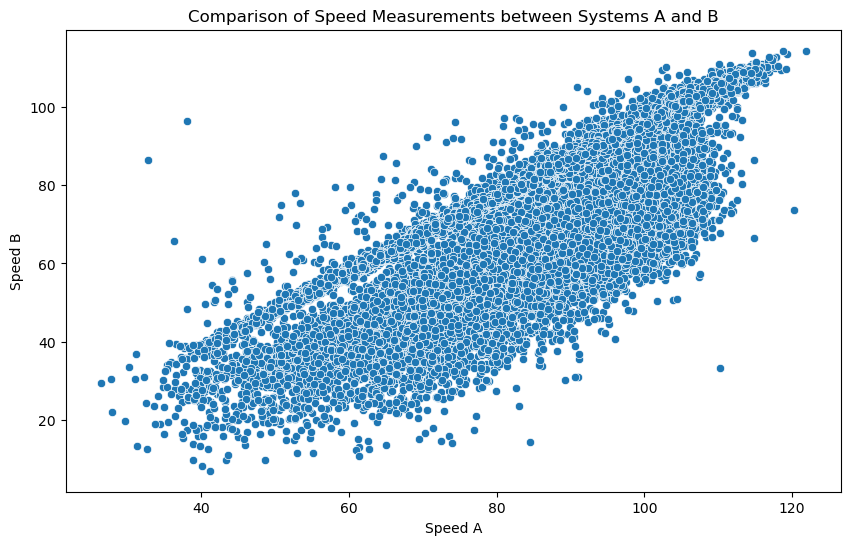

In [5]:
# Visualize differences between systems A and B
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='speed_A', y='speed_B')
plt.xlabel('Speed A')
plt.ylabel('Speed B')
plt.title('Comparison of Speed Measurements between Systems A and B')
plt.show()

In [6]:
# Calculate summary statistics for the differences
speed_difference = df['speed_A'] - df['speed_B']
difference_stats = speed_difference.describe()
difference_stats

count    64943.000000
mean         8.651512
std          9.838122
min        -58.414730
25%          3.331220
50%          4.181930
75%          6.430950
max         76.960100
dtype: float64

## Handling Missing Data

In [7]:
# Assess the extent of missing data
missing_percentage = (missing_values / len(df)) * 100
missing_percentage

batter       0.000000
pitcher      0.000000
hittype      0.000000
speed_A     10.319591
vangle_A    10.319591
speed_B      1.910733
vangle_B     1.910733
dtype: float64

In [8]:
# Impute missing values with the mean
df['speed_A'].fillna(df['speed_A'].mean(), inplace=True)
df['vangle_A'].fillna(df['vangle_A'].mean(), inplace=True)
df['speed_B'].fillna(df['speed_B'].mean(), inplace=True)
df['vangle_B'].fillna(df['vangle_B'].mean(), inplace=True)

In [9]:
df.isna().sum()

batter      0
pitcher     0
hittype     0
speed_A     0
vangle_A    0
speed_B     0
vangle_B    0
dtype: int64

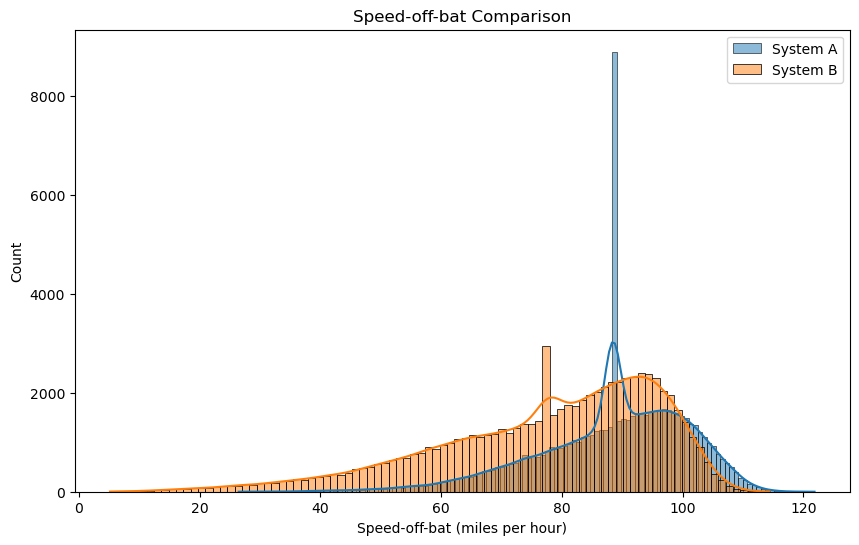

In [10]:
# Histogram for speed-off-bat
plt.figure(figsize=(10, 6))
sns.histplot(df['speed_A'], label='System A', kde=True)
sns.histplot(df['speed_B'], label='System B', kde=True)
plt.title('Speed-off-bat Comparison')
plt.xlabel('Speed-off-bat (miles per hour)')
plt.legend()

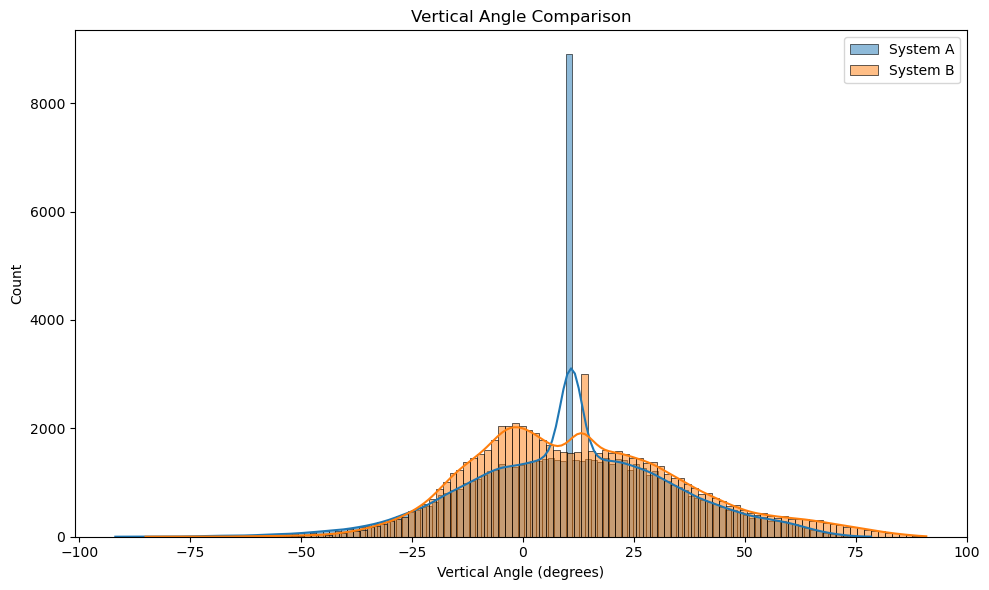

In [11]:
# Histogram for vertical angle
plt.figure(figsize=(10, 6))
sns.histplot(df['vangle_A'], label='System A', kde=True)
sns.histplot(df['vangle_B'], label='System B', kde=True)
plt.title('Vertical Angle Comparison')
plt.xlabel('Vertical Angle (degrees)')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
speed_a = df['speed_A']
speed_b = df['speed_B']

# Perform paired t-test
t_statistic, p_value = ttest_rel(speed_a, speed_b)

# Display the results
print(f"Paired t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the speed-off-bat measurements of System A and B.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the speed-off-bat measurements of System A and B.")

Paired t-test results:
T-statistic: 219.8345415479465
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the speed-off-bat measurements of System A and B.


## Check for outliers and inconsistencies

Number of outliers in speed_A: 1701


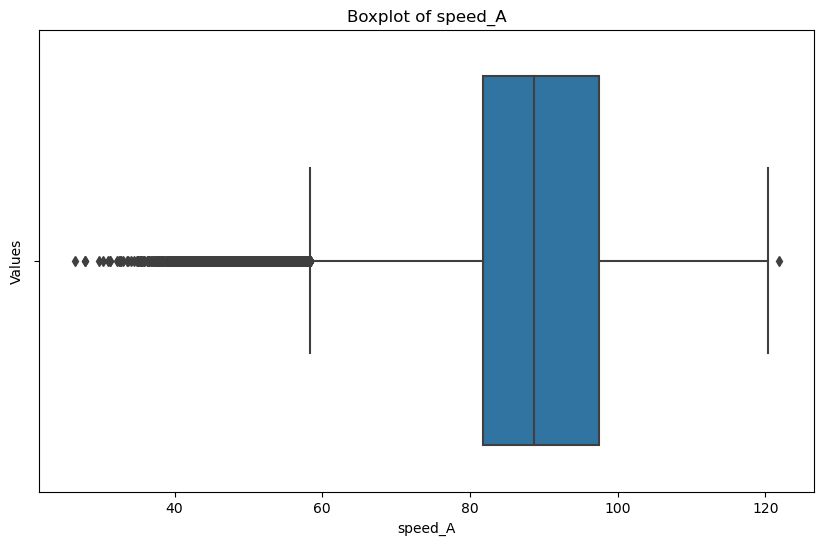

In [13]:
q1 = df["speed_A"].quantile(0.25)
q3 = df["speed_A"].quantile(0.75)
iqr = q3 - q1

outliers = df[(df["speed_A"] < (q1 - 1.5 * iqr)) | (df["speed_A"] > (q3 + 1.5 * iqr))]
print(f"Number of outliers in speed_A: {len(outliers)}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["speed_A"])

plt.title('Boxplot of speed_A')
plt.xlabel('speed_A')
plt.ylabel('Values')

plt.show()

Number of outliers in speed_B: 1075


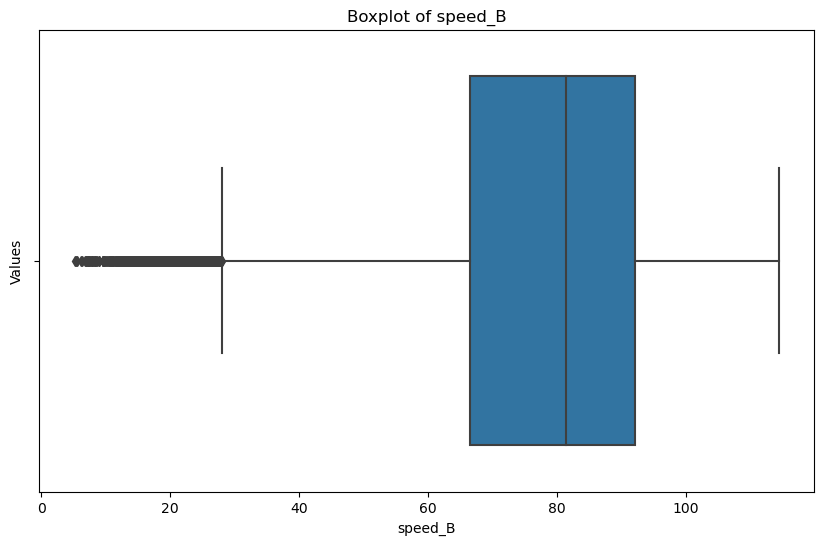

In [14]:
q1 = df["speed_B"].quantile(0.25)
q3 = df["speed_B"].quantile(0.75)
iqr = q3 - q1

# Use parentheses to group the conditions properly
outliers = df[(df["speed_B"] < (q1 - 1.5 * iqr)) | (df["speed_B"] > (q3 + 1.5 * iqr))]
print(f"Number of outliers in speed_B: {len(outliers)}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["speed_B"])

plt.title('Boxplot of speed_B')
plt.xlabel('speed_B')
plt.ylabel('Values')

plt.show()

## Hit Type Analysis

In [15]:
hittype_groups = df.groupby("hittype")
for hittype, group in hittype_groups:
    print(f"\nHit Type: {hittype}")
    print(f"Average speed_A: {group['speed_A'].mean():.2f}")
    print(f"Average speed_B: {group['speed_B'].mean():.2f}")


Hit Type: U
Average speed_A: 90.61
Average speed_B: 75.12

Hit Type: fly_ball
Average speed_A: 90.03
Average speed_B: 86.19

Hit Type: ground_ball
Average speed_A: 86.46
Average speed_B: 68.42

Hit Type: line_drive
Average speed_A: 92.78
Average speed_B: 88.67

Hit Type: popup
Average speed_A: 80.69
Average speed_B: 72.14


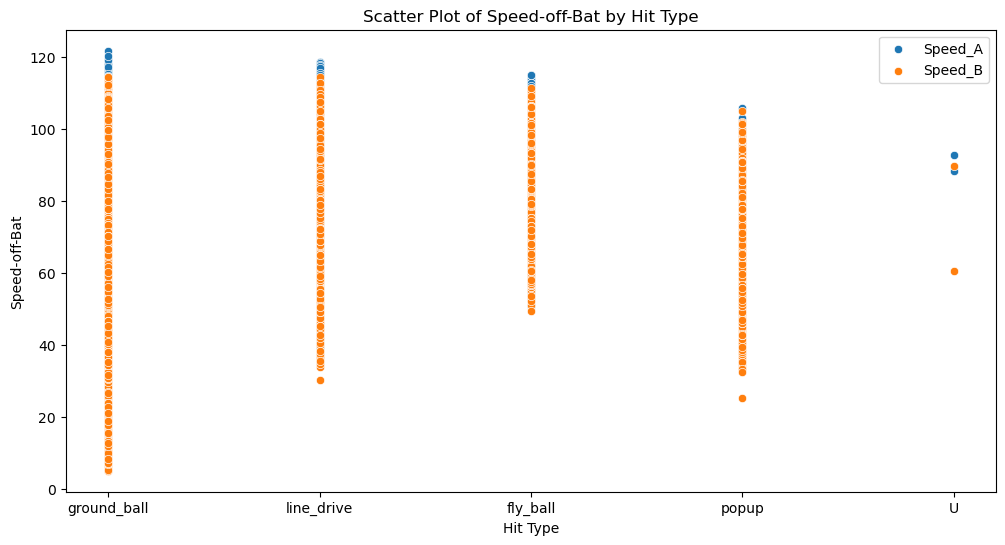

In [16]:
# Scatter plot for Speed-off-Bat
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hittype', y='speed_A', data=df, label='Speed_A')
sns.scatterplot(x='hittype', y='speed_B', data=df, label='Speed_B')
plt.title('Scatter Plot of Speed-off-Bat by Hit Type')
plt.xlabel('Hit Type')
plt.ylabel('Speed-off-Bat')
plt.legend()
plt.show()

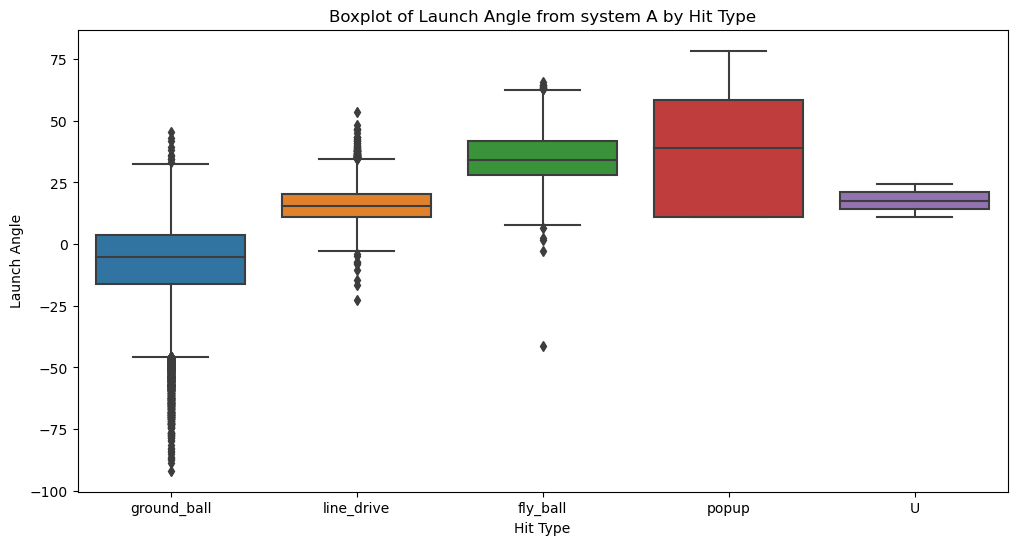

In [17]:
# Boxplot for Launch Angle
plt.figure(figsize=(12, 6))
sns.boxplot(x='hittype', y='vangle_A', data=df)
plt.title('Boxplot of Launch Angle from system A by Hit Type')
plt.xlabel('Hit Type')
plt.ylabel('Launch Angle')
plt.show()

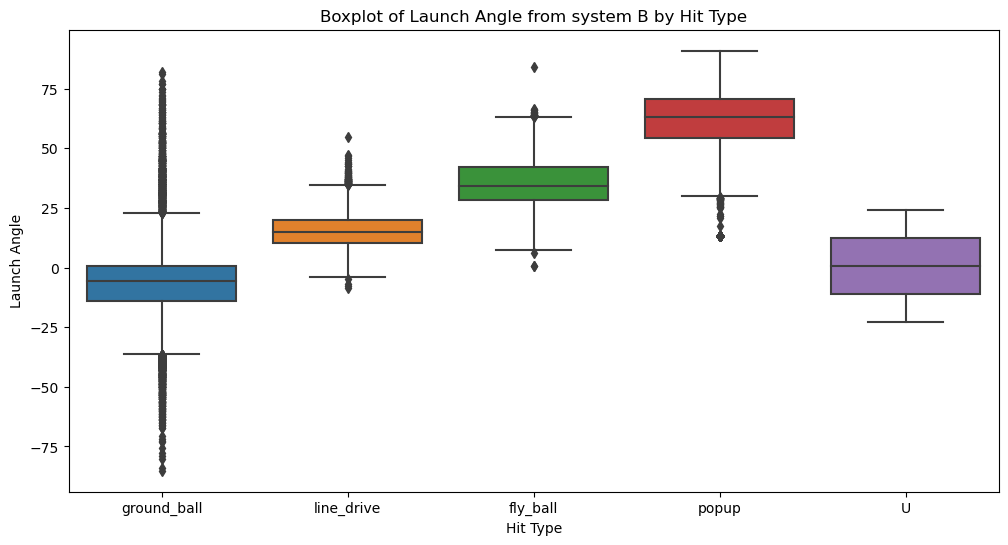

In [18]:
# Boxplot for Launch Angle
plt.figure(figsize=(12, 6))
sns.boxplot(x='hittype', y='vangle_B', data=df)
plt.title('Boxplot of Launch Angle from system B by Hit Type')
plt.xlabel('Hit Type')
plt.ylabel('Launch Angle')
plt.show()

In [19]:
df['batter'].nunique()

816

There is 816 unique batters

In [20]:
# Calculate the average speed for each batter in system A and B
average_speed_per_batter = df.groupby('batter')[['speed_A', 'speed_B']].mean().reset_index()
average_speed_per_batter.head()

,batter,speed_A,speed_B
0,1,89.201413,77.007720
1,2,82.543425,61.125150
2,3,92.031336,77.935085
3,4,89.741957,77.944173
4,5,88.792730,78.812302


In [21]:
# Create a new column for the true average speed, which is an average of a combination of A and B
average_speed_per_batter['true_speed'] = average_speed_per_batter[['speed_A', 'speed_B']].mean(axis=1)
average_speed_per_batter.head()

,batter,speed_A,speed_B,true_speed
0,1,89.201413,77.007720,83.104566
1,2,82.543425,61.125150,71.834287
2,3,92.031336,77.935085,84.983210
3,4,89.741957,77.944173,83.843065
4,5,88.792730,78.812302,83.802516


In [22]:
# Features and target variable
features = ['speed_A', 'speed_B']
target = 'true_speed'

## Train/test split

In [23]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(average_speed_per_batter, test_size=0.2, random_state=42)
train_data.head()

,batter,speed_A,speed_B,true_speed
448,449,89.915955,78.740162,84.328059
335,336,89.555438,74.884081,82.219760
294,295,88.327599,77.812225,83.069912
684,685,85.787792,68.787312,77.287552
79,80,85.441078,75.091068,80.266073


## Train/Val split

In [24]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
val_data.head()

,batter,speed_A,speed_B,true_speed
458,459,89.218001,79.351229,84.284615
149,150,83.765662,79.200292,81.482977
179,180,87.305068,78.129980,82.717524
522,523,92.195762,81.249612,86.722687
73,74,89.887864,83.958030,86.922947


## Define dedault estimators

In [25]:
elastic_net = Pipeline([
    ("elastic_net", ElasticNet(random_state=42))
])

## Build the composite estimator

In [26]:
composite_estimator = Pipeline(steps=[ 
    ('estimator', elastic_net)])
composite_estimator

Pipeline(steps=[('estimator',
                 Pipeline(steps=[('elastic_net',
                                  ElasticNet(random_state=42))]))])

## Train the default model

In [27]:
composite_estimator.fit(train_data[features], train_data[target])

Pipeline(steps=[('estimator',
                 Pipeline(steps=[('elastic_net',
                                  ElasticNet(random_state=42))]))])

## evaluate the default model on the validation set by bootstrapping without refit

In [28]:
def bootstrap_estimator(estimator, X, y, n_bootstraps, random_state=None):
    rmse_scores = []
    for _ in range(n_bootstraps):
        # Sample data with replacement
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Fit the estimator without refitting
        estimator.fit(X_train, y_train)

        # Predict on the test set
        y_pred = estimator.predict(X_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

    return rmse_scores

In [29]:
rmse_scores = bootstrap_estimator(composite_estimator, val_data[features], val_data[target], n_bootstraps=20)

# Analyze the distribution of RMSE scores
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Standard deviation of RMSE: {np.std(rmse_scores):.4f}")

Average RMSE: 0.1212
Standard deviation of RMSE: 0.0000


## Hyperparameter tuning

### Set up hyperparameter grid

In [30]:
param_grid = {
    'estimator__elastic_net__alpha': [0.01, 0.1, 1.0],
    'estimator__elastic_net__l1_ratio': [0.1, 0.5, 0.9],
}

In [31]:
grid_search = GridSearchCV(composite_estimator, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        Pipeline(steps=[('elastic_net',
                                                         ElasticNet(random_state=42))]))]),
             n_jobs=-1,
             param_grid={'estimator__elastic_net__alpha': [0.01, 0.1, 1.0],
                         'estimator__elastic_net__l1_ratio': [0.1, 0.5, 0.9]},
             scoring='neg_mean_squared_error')

In [32]:
grid_search.fit(train_data[features], train_data[target])

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'estimator__elastic_net__alpha': 0.01, 'estimator__elastic_net__l1_ratio': 0.1}


## evaluate the tuned model on the validation set by bootstrapping without refit

In [33]:
best_estimator = grid_search.best_estimator_

In [34]:
rmse_scores = bootstrap_estimator(best_estimator, val_data[features], val_data[target], n_bootstraps=20)

# Analyze the distribution of RMSE scores
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Standard deviation of RMSE: {np.std(rmse_scores):.4f}")

Average RMSE: 0.0009
Standard deviation of RMSE: 0.0000


## evaluate the tuned model on the test set by bootstrapping without refit

In [35]:
rmse_scores = bootstrap_estimator(best_estimator, test_data[features], test_data[target], n_bootstraps=20)

# Analyze the distribution of RMSE scores
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Standard deviation of RMSE: {np.std(rmse_scores):.4f}")

Average RMSE: 0.0006
Standard deviation of RMSE: 0.0000


In [36]:
# For example, to predict the true average speed for batter_id = 007:
predicted_speed = best_estimator.predict([[88.224668, 81.593146]])
print(f'Predicted True Average Speed for Batter 123: {predicted_speed[0]}')

Predicted True Average Speed for Batter 123: 84.90867788040934


C:\Users\disle\miniconda3\envs\base_ds_v4\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
